## Code

In [31]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cmcrameri import cm as cmc
import seaborn as sns

from utils import hnorm_on_xygrid, gradh_on_xygrid, load_config, \
    default_params, axes_styling, depth_following_contour, integrated_zonal_momentum_terms, \
        windforcing, interp_ds

In [32]:
sns.set_theme("paper")

### Reading data

In [33]:
# whitch experiemt to analyse
config = "slope-003"

# option to select subset of domain. 0 to 90 is full domain
xstart = 0
xstop = 90
params = load_config(f"/itf-fi-ml/home/alsjur/temporal-topo-flow/slope/configs/{config}.json", default_params)

ds = xr.open_dataset(f"/itf-fi-ml/home/alsjur/temporal-topo-flow/slope/output/{config}.nc").squeeze()
ds = ds.isel(xC=slice(xstart,xstop),xF=slice(xstart,xstop+1))

# calculate total area
area = params["Ly"]*(xstop-xstart)*params["dx"]

# read in gradient of bahtymetry and norm of grad of bathymetry
hnorm = hnorm_on_xygrid(params, ds)
hgrad = gradh_on_xygrid(params, ds)
hgrad["dh"] = np.sqrt(hgrad.dhdx**2+hgrad.dhdx**2)


# add surface stress as variable to dataset
ds["tauy"] = (["time", "yC", "xC"], -np.ones_like(ds.h.values)*windforcing(ds.time, params)[:,None,None])
ds["taux"] = ds.tauy*0
ds

<xarray.Dataset>
Dimensions:  (xC: 90, yF: 90, xF: 91, yC: 90, time: 1537)
Coordinates:
    zC       float64 0.0
    zF       float64 0.0
  * xC       (xC) float64 500.0 1.5e+03 2.5e+03 ... 8.75e+04 8.85e+04 8.95e+04
  * yF       (yF) float64 0.0 1e+03 2e+03 3e+03 ... 8.7e+04 8.8e+04 8.9e+04
  * xF       (xF) float64 0.0 1e+03 2e+03 3e+03 ... 8.8e+04 8.9e+04 9e+04
  * yC       (yC) float64 500.0 1.5e+03 2.5e+03 ... 8.75e+04 8.85e+04 8.95e+04
  * time     (time) timedelta64[ns] 0 days 00:00:00 ... 192 days 00:00:00
Data variables: (12/16)
    omegav   (time, yF, xF) float64 ...
    duvhdy   (time, yF, xF) float64 ...
    dvvhdy   (time, yC, xC) float64 ...
    omegau   (time, yF, xF) float64 ...
    duuhdy   (time, yF, xF) float64 ...
    detadx   (time, yC, xF) float64 ...
    ...       ...
    dvvhdx   (time, yF, xF) float64 ...
    duuhdx   (time, yC, xC) float64 ...
    duvhdx   (time, yC, xC) float64 ...
    u        (time, yC, xF) float64 ...
    tauy     (time, yC, xC) float64 2.453e-06 2.453e-06 ... 2.453e-06 2.453e-06
    taux     (time, yC, xC) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    time averaging stride:  Output was time averaged with a stride of 1 itera...
    interval:               10800.0
    time_averaging_window:  10800.0
    time_averaging_stride:  1
    Oceananigans:           This file was generated using Oceananigans v0.91.14
    Julia:                  This file was generated using Julia Version 1.9.4...
    output time interval:   Output was saved every 3 hours.
    date:                   This file was generated on 2025-04-10T08:54:09.217.
    time averaging window:  Output was time averaged with a window size of 3 ...
    schedule:               TimeInterval

### Cartesian integrals

In [34]:
# xmomentum area integrals
idxs = np.arange(xstop-xstart)

termlist = []
for xidx in idxs:
    terms = integrated_zonal_momentum_terms(params, ds, xidx).squeeze()
    termlist.append(terms)
    
Xterms = xr.concat(termlist, dim="x")
Xresults = Xterms.mean("x")
Xresults

<xarray.Dataset>
Dimensions:       (time: 1537)
Coordinates:
    zC            float64 0.0
    zF            float64 0.0
  * time          (time) timedelta64[ns] 0 days 00:00:00 ... 192 days 00:00:00
Data variables:
    surfstress    (time) float64 2.453e-06 7.355e-06 ... -2.455e-06 2.453e-06
    nonlin        (time) float64 0.0 -6.591e-30 ... 9.356e-22 -2.28e-22
    massflux      (time) float64 0.0 -6.768e-09 ... -1.437e-07 -1.499e-07
    formstress    (time) float64 0.0 -5.76e-09 ... 2.628e-06 1.683e-06
    bottomstress  (time) float64 0.0 -2.001e-08 ... 2.967e-05 2.866e-05

### Depth-following integrals

In [35]:
def interp2c(var, contour, coords=["xC", "yC"]):
    """Interpolates variable to contour"""
    if set(["xC", "yC"]) == set(coords):
        vart = var.interp(xC=contour.x, yC=contour.y)
    elif set(["xC", "yF"]) == set(coords):
        vart = var.interp(xC=contour.x, yF=contour.y)
    elif set(["xF", "yC"]) == set(coords):
        vart = var.interp(xF=contour.x, yC=contour.y)
    elif set(["xF", "yF"]) == set(coords):
        vart = var.interp(xF=contour.x, yF=contour.y)
        
    return vart

def weighted_contour_intgral(u, v, dh, contour):
    ut = interp2c(u, contour)
    vt = interp2c(v, contour)
    dht = interp2c(dh, contour)
    
    uc = ut*contour.dtdx + vt*contour.dtdy 
    Uc = (uc*contour.dl/dht).sum("j")
    
    return Uc 

In [36]:
# interpolate variables to grid center
ds = interp_ds(ds, params, ["duvhdy", "duuhdy", "dvvhdx", "detady", "detadx", "u", "v"])

# hmomentum area integrals
g = params["gravitational_acceleration"]
idxs = np.arange(xstop-xstart)

termlist = []
Hs = []
idy = int(params["lam"]/params["dy"]*0.5)
for idx in idxs:
    H = ds.h.isel(time=1,xC=idx, yC=idy).values
    
    terms = xr.Dataset()
    contour = depth_following_contour(params, H)
    
    nonlinx = ds.duuhdx+ds.duvhdy
    nonliny = ds.duvhdx+ds.dvvhdy
    
    formstress = -g*H*weighted_contour_intgral(ds.detadx, ds.detady, hgrad.dh, contour)
    #nonlin = H*weighted_contour_intgral(-ds.omegav, ds.omegau, hgrad.dh, contour)  # this was what I calculated in earlier versions
    nonlin = weighted_contour_intgral(nonlinx, nonliny, hgrad.dh, contour)
    surfstress = weighted_contour_intgral(ds.taux, ds.tauy, hgrad.dh, contour)
    bottomstress = -params["R"]*weighted_contour_intgral(ds.u, ds.v, hgrad.dh, contour)
    
    terms["formstress"] = formstress
    terms["nonlin"] = nonlin
    terms["surfstress"] = surfstress
    terms["bottomstress"] = bottomstress
    
    termlist.append(terms)
    Hs.append(float(H))
    
Hterms = xr.concat(termlist, dim="H")#/area
dH = np.gradient(np.array(Hs))
Hterms["dH"] = (["H"], dH)
Hresults = (Hterms*Hterms.dH).sum("H")/area

/itf-fi-ml/home/alsjur/temporal-topo-flow/slope/code/utils.py:131: RuntimeWarning:

invalid value encountered in arctanh

/itf-fi-ml/home/alsjur/temporal-topo-flow/slope/code/utils.py:139: RuntimeWarning:

invalid value encountered in arctanh

/itf-fi-ml/home/alsjur/temporal-topo-flow/slope/code/utils.py:141: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.

/itf-fi-ml/home/alsjur/.conda/envs/general/lib/python3.12/site-packages/xarray/core/missing.py:562: RuntimeWarning:

All-NaN slice encountered

/itf-fi-ml/home/alsjur/.conda/envs/general/lib/python3.12/site-packages/xarray/core/missing.py:563: RuntimeWarning:

All-NaN slice encountered

/itf-fi-ml/home/alsjur/.conda/envs/general/lib/python3.12/site-packages/xarray/core/missing.py:562: RuntimeWarning:

All-NaN slice encountered

/itf-fi-ml/home/alsjur/.conda/envs/general/lib/python3.12/site-packages/xarray/core/missing.py:563: RuntimeWarning:

All-NaN slice e

## Plots

### Depth contours

Text(0, 0.5, 'y [km]')

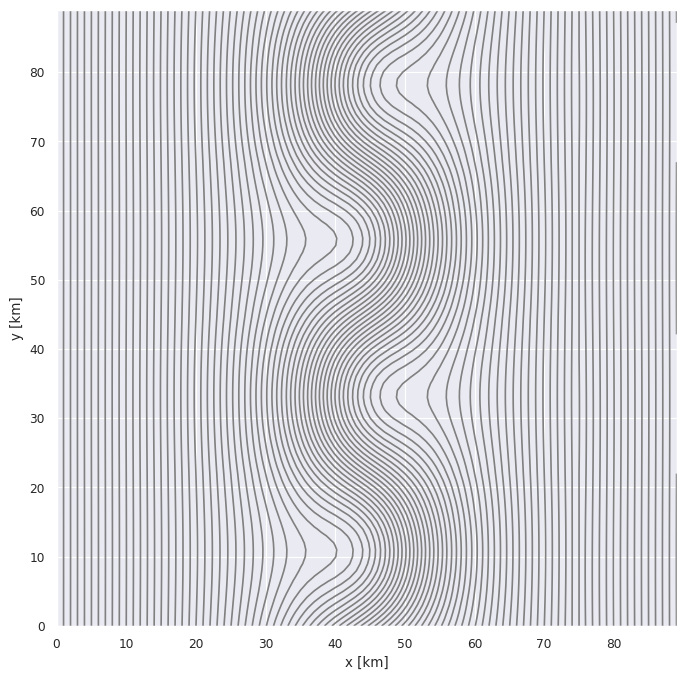

In [37]:
fig, ax = plt.subplots(figsize=(8,8))
ax.contour(ds.h.isel(time=1), levels=Hs, colors="grey")
ax.set_xlabel("x [km]")
ax.set_ylabel("y [km]")

### Depth and area integrated momentum terms 

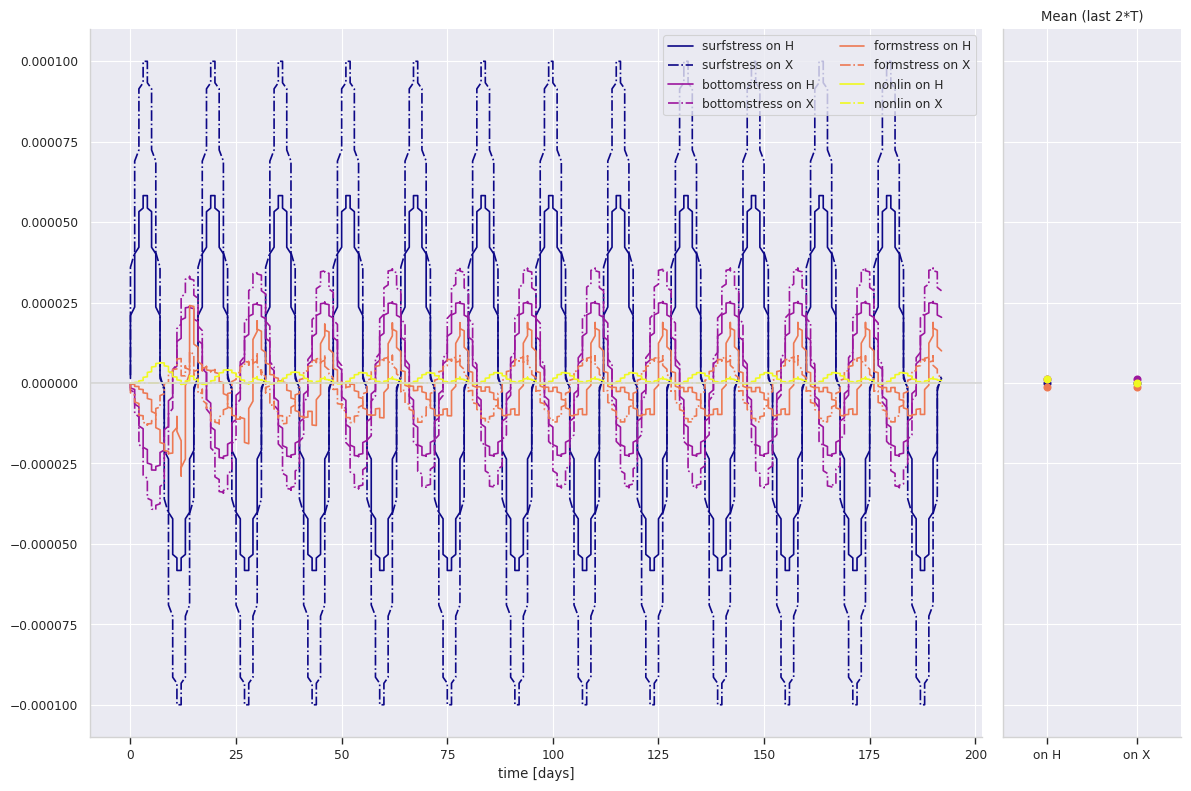

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Set up subplots: 1 row, 2 columns
fig, (ax_main, ax_mean) = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 8), 
    gridspec_kw={'width_ratios': [5, 1]}, 
    sharey=True
)

axes_styling(ax_main)
axes_styling(ax_mean)

terms2plot = ["surfstress", "bottomstress", "formstress", "nonlin"]
cmap = plt.colormaps["plasma"]
n = max(len(terms2plot), 2)
colors = [cmap(1 - i / (n - 1)) for i in range(n)]

t = ds.time / (60 * 60 * 24 * 1e9)
tn = int(params["T"] / params["outputtime"])

# Plot time series
for term, color in zip(terms2plot, colors[::-1]):
    onX = Xresults[term]
    onH = Hresults[term]
    mean_H = onH.isel(time=slice(-2 * tn, None)).mean("time").item()
    mean_X = onX.isel(time=slice(-2 * tn, None)).mean("time").item()

    ax_main.plot(t, onH, label=f"{term} on H", color=color)
    ax_main.plot(t, onX, label=f"{term} on X", linestyle="-.", color=color)

    # Plot mean values as markers in right panel
    ax_mean.plot(1, mean_H, marker="o", 
                 color=color, 
                 label=f"{term} on H"
                 )
    ax_mean.plot(2, mean_X, marker="o", 
                 color=color, 
                 label=f"{term} on X"
                 )

# Styling main panel
ax_main.axhline(0, color="lightgray")
ax_main.set_xlabel("time [days]")
ax_main.legend(ncols=2)

# Styling mean panel
ax_mean.set_xlim(0.5, 2.5)
ax_mean.set_xticks([1, 2])
ax_mean.set_xticklabels(["on H", "on X"])
ax_mean.set_title("Mean (last 2*T)")
#ax_mean.grid(False)

# Save
fig.tight_layout()
fig.savefig(f"../figures/terms/area/{config}_area_momentum.pdf")


#### Interactive plot
This plot is interactive. Click on the legend to toggle visibility.
It is also possible to zoom and pan around.

In [39]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.colors as pc

# Time in days
t = ds.time / (60 * 60 * 24 * 1e9)
tn = int(params["T"] / params["outputtime"])

# Use a perceptually uniform colormap (batlow-like fallback)
terms2plot = ["formstress", "surfstress", "bottomstress", "nonlin"]
n = max(len(terms2plot), 2)

# If you don’t have cmc.batlow in Plotly, define colors manually or use one of Plotly's colormaps
colors = pc.sample_colorscale("Turbo", [1 - i / (n - 1) for i in range(n)])


# Create subplot: 1 row, 2 columns
fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.85, 0.15],  # Adjust space as needed
    shared_yaxes=True,
    horizontal_spacing=0.05,
    subplot_titles=("Time series", "Mean (last 2*T)")
)

# First loop: add all "on H"
for term, color in zip(terms2plot, colors[::-1]):
    onH = Hresults[term]
    fig.add_trace(go.Scatter(
        x=t, y=onH, mode="lines", name=f"{term} on H",
        line=dict(color=color),
        legendgroup=f"{term}_H"
    ), row=1, col=1)
    
    # Mean dots in right subplot
    mean_H = onH.isel(time=slice(-2 * tn, None)).mean("time").item()
    fig.add_trace(go.Scatter(
        x=[0.7], y=[mean_H], mode="markers",
        marker=dict(symbol="circle", size=10, color=color),
        name=f"{term} on H (mean)",
        showlegend=False, legendgroup=f"{term}_H"
    ), row=1, col=2)

# Second loop: add all "on X"
for term, color in zip(terms2plot, colors[::-1]):
    onX = Xresults[term]
    fig.add_trace(go.Scatter(
        x=t, y=onX, mode="lines", name=f"{term} on X",
        line=dict(color=color, dash="dash"),
        legendgroup=f"{term}_X"
    ), row=1, col=1)
    
    mean_X = onX.isel(time=slice(-2 * tn, None)).mean("time").item()
    fig.add_trace(go.Scatter(
        x=[1.3], y=[mean_X], mode="markers",
        marker=dict(symbol="x", size=10, color=color),
        name=f"{term} on X (mean)",
        showlegend=False, legendgroup=f"{term}_X"
    ), row=1, col=2)

# Reference zero line in time series
fig.add_trace(go.Scatter(
    x=[t[0], t[-1]], y=[0, 0], mode="lines",
    line=dict(color="lightgray", width=1),
    showlegend=False
), row=1, col=1)

fig.update_layout(
    width=1000,
    height=800,
    legend=dict(
        orientation="h",
        x=0,
        y=1.1,
        traceorder="normal",  # Respect the order we define
        itemwidth=80
    ),
    xaxis_title="time [days]",
    xaxis2=dict(
        range=[0.5, 1.5],  # Fix x range
        fixedrange=True,   # Prevent zoom/pan
        showticklabels=False,
        showgrid=False,
        zeroline=False
    ),
    yaxis_title="value",
    margin=dict(l=60, r=60, t=60, b=60)
)

fig.write_html(f"../figures/terms/area/{config}_area_momentum.html")